# 24784 - Trustworthy AI Autonomy (Homework 2)

## Instructions
In this homework you are going to experiment with two model-based reinforcement learning (MBRL) algorithms. You will first code the missing part in models using [PyTorch](https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html) and [GPyTorch](https://docs.gpytorch.ai/en/stable/).
You will then implement your algorithms to control a vehicle in an parking in [highway-env](https://github.com/eleurent/highway-env). This homework is modefied based on the colab [template](https://colab.research.google.com/github/eleurent/highway-env/blob/master/scripts/parking_model_based.ipynb#scrollTo=NwCDLD1wfvi2) from Edouard Leurent.

The main experiments uses **parking-v0** environment. The goal is to park a vehicle to a given goal location with the appropriate heading by controlling the gas pedal and steering angle.


## 0. Install and import packages



In [1]:
# Install environment
!pip install highway-env==1.5
!pip install pyvirtualdisplay
!apt-get update

# Install visualization and Gaussian processes dependencies
!apt-get install -y xvfb python3-opengl ffmpeg -y
!pip install gpytorch
!pip install moviepy
!pip install imageio_ffmpeg


!pip install numpy==1.23.5
!pip install gym==0.25.2

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Hit:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease
Hit:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Hit:7 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Hit:8 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:9 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Hit:10 http://security.ubuntu.com/ubuntu jammy-security InRelease
Reading package lists... Done
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
python3-opengl is already the newest version (3.1.5+dfsg-1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
xvfb is alre

In [2]:
# Import environment
import gym
import highway_env
import warnings
warnings.filterwarnings('ignore')

# Models and computation
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from collections import namedtuple
import gpytorch
from gpytorch.constraints import GreaterThan, Positive, LessThan

#suppress trivial warning from gpytorch
import warnings
warnings.filterwarnings("ignore", message="CG terminated in 1000 iterations")

# Visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm.notebook import trange
from IPython import display as ipythondisplay
from pyvirtualdisplay import Display
from gym.wrappers import RecordVideo
import base64

# IO
from pathlib import Path

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


Here is a simple helper function for visualization of episodes directly in this Colab notebook:



In [3]:
display = Display(visible=0, size=(1400, 900))
display.start()

def show_videos(path="videos"):
    html = []
    for mp4 in Path(path).glob("*.mp4"):
        video_b64 = base64.b64encode(mp4.read_bytes())
        html.append('''<video alt="{}" autoplay
                      loop controls style="height: 400px;">
                      <source src="data:video/mp4;base64,{}" type="video/mp4" />
                 </video>'''.format(mp4, video_b64.decode('ascii')))
    ipythondisplay.display(ipythondisplay.HTML(data="<br>".join(html)))

Here we set up the parking environment

In [4]:
env = gym.make("parking-v0") #instantiate the parking environment
VIDEO_PATH = './video' #designate the video path
env = RecordVideo(env, video_folder='./videos', episode_trigger=lambda e: True, new_step_api=True )
env.unwrapped.set_record_video_wrapper(env) #set up virtual monitor to store the video files at VIDEO_PATH dir

To see the configuration, run the following:

In [5]:
env.unwrapped.config

{'observation': {'type': 'KinematicsGoal',
  'features': ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h'],
  'scales': [100, 100, 5, 5, 1, 1],
  'normalize': False},
 'action': {'type': 'ContinuousAction'},
 'simulation_frequency': 15,
 'policy_frequency': 5,
 'other_vehicles_type': 'highway_env.vehicle.behavior.IDMVehicle',
 'screen_width': 600,
 'screen_height': 300,
 'centering_position': [0.5, 0.5],
 'scaling': 7,
 'show_trajectories': False,
 'render_agent': True,
 'offscreen_rendering': False,
 'manual_control': False,
 'real_time_rendering': False,
 'reward_weights': [1, 0.3, 0, 0, 0.02, 0.02],
 'success_goal_reward': 0.12,
 'collision_reward': -5,
 'steering_range': 0.7853981633974483,
 'duration': 100,
 'controlled_vehicles': 1}

## 1.1. Running an episode with random actions

The environment is a `GoalEnv` type, which means the agent receives a dictionary containing both the current `observation` and the `desired_goal` that conditions its policy. In this case, `observation` or `achieved_goal` is the current states and `desired_goal` are the target.

In [6]:
#run an episode
env.reset() #resetting the environment to start from a randomized state
done = False

rewards = []
states = []

while not done:
    action = env.action_space.sample() #use random actions
    obs, reward, done, _, info = env.step(action)    # REPLACE THE THREE DOTS WITH YOUR OWN CODE

    #store the state and reward in a list
    rewards.append(reward) #store the reward in a list
    states.append(obs)
    final_state_img = env.render(mode="rgb_array") # Rendering the final state image
env.close()

#Which variable does store the achieved_goal or observation (s_n) and the desired_goal (s^*)?
achieved_goal = [state["achieved_goal"] for state in states]
desired_goal = states[-1]["desired_goal"]




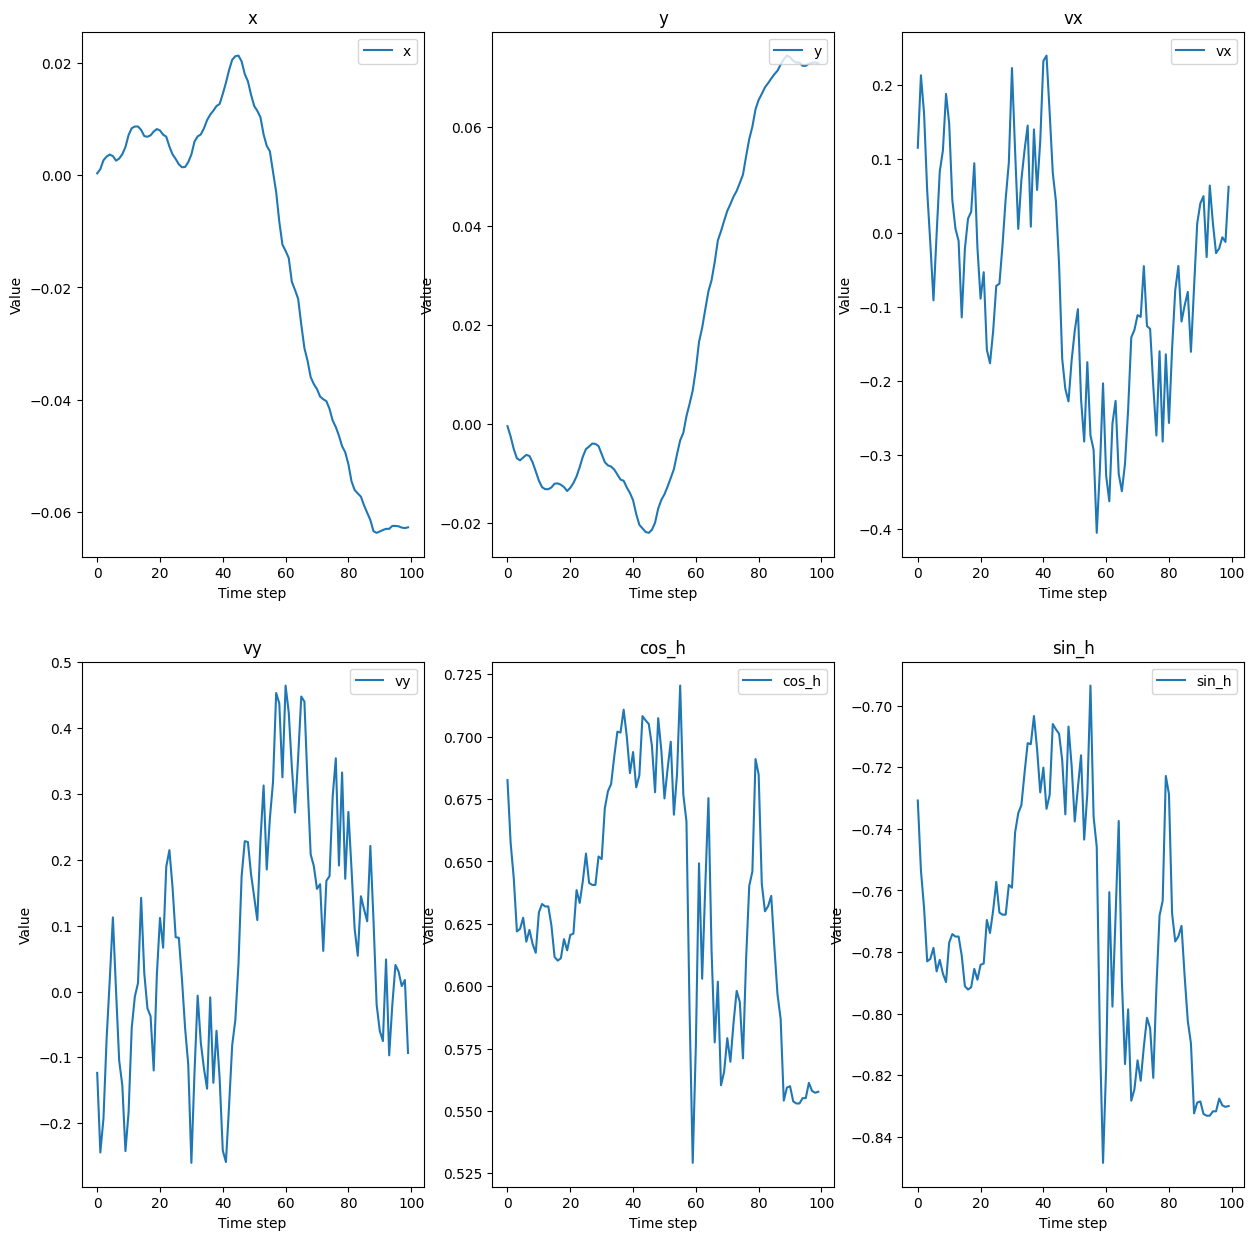

In [7]:
features = ['x', 'y', 'vx', 'vy', 'cos_h', 'sin_h']
achieved_goal = np.array(achieved_goal)
plt.figure(figsize=(15,15))
for i in range(achieved_goal.shape[1]):
  plt.subplot(2,3,i+1)
  plt.plot(achieved_goal[:,i], label=features[i])
  plt.legend(loc="upper right")
  plt.title(features[i])
  plt.xlabel("Time step")
  plt.ylabel("Value")
plt.show()

In [8]:
# Print the Final state and Desired state
print("Final state at 100th time step :", achieved_goal[-1,:])
print("Desired state :", desired_goal)

Final state at 100th time step : [-0.06271608  0.0729472   0.06265756 -0.09325798  0.55768866 -0.83005022]
Desired state : [ 1.800000e-01 -1.400000e-01  0.000000e+00  0.000000e+00  6.123234e-17
 -1.000000e+00]


## 1.2. Reward definition

The reward (or more specifically penalty, as it uses negative sign) here is the difference between the current state to the targe (parking space).

Text(0.5, 1.0, 'Manual Calculated Weighted Norm vs Time step')

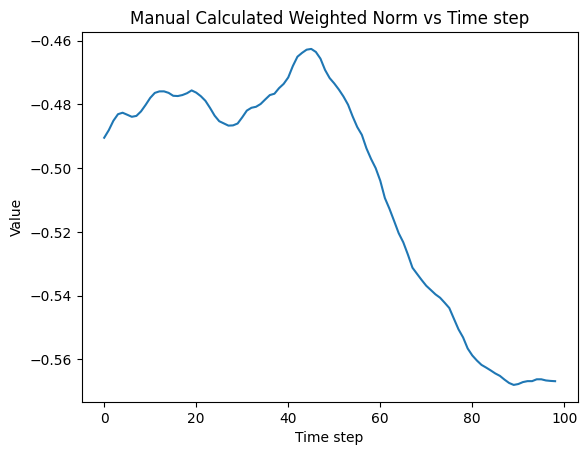

In [9]:
#Negative reward
states_labels = env.config['observation']['features'] #the labels for the states
states_scales = env.config['observation']['scales'] #the scales for the states (if needed for plotting)

weights = np.array([1, 0.3, 0, 0, 0.02, 0.02]) #weights
l2norm = np.sqrt(np.square(achieved_goal - desired_goal))
weighted_norm = -np.sqrt(np.sum(l2norm*weights, axis = 1)) # REPLACE THE THREE DOTS WITH YOUR OWN CODE

#plot the weighted norm over time
# REPLACE THE THREE DOTS WITH YOUR OWN CODE
plt.plot(weighted_norm[:-1])
plt.xlabel("Time step")
plt.ylabel("Value")
plt.title("Manual Calculated Weighted Norm vs Time step")


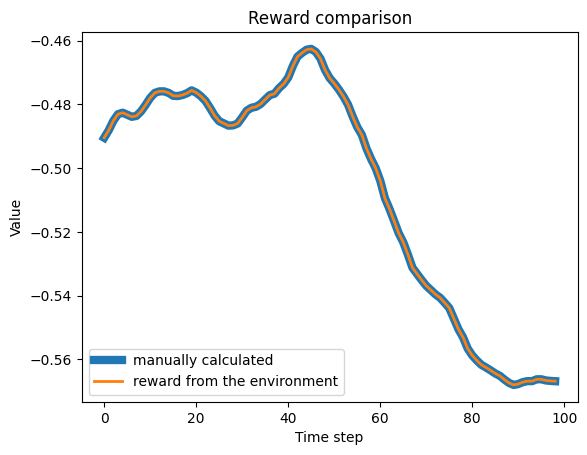

In [10]:
#not needed, but as hinted:
#might be useful to compare the calculated weighted norm with the actual reward
#they should be the same if your calculation is correct

#Reward comparison
plt.plot(weighted_norm[:-1], lw=6, label="manually calculated")
plt.plot(rewards[:-1], lw=2, label="reward from the environment")
plt.title('Reward comparison')
plt.xlabel('Time step')
plt.ylabel("Value")
plt.legend()
plt.show()

##1.3 Final reward and vehicle trajectory



Reward of the final episode: -0.566703635048096


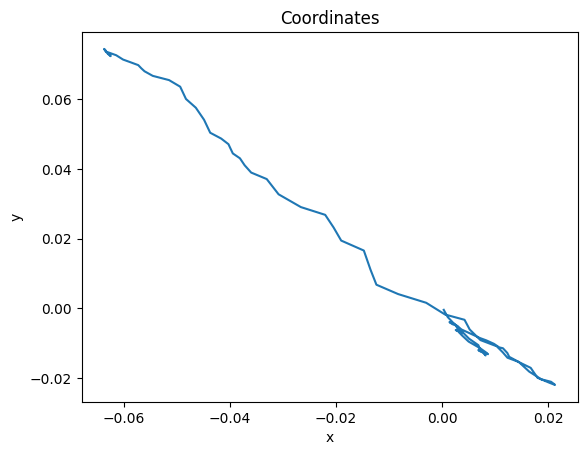

In [11]:
# final reward
final_reward = rewards[-1] # REPLACE THE THREE DOTS WITH YOUR OWN CODE

# Plot the trajectory of the vehicle (x and y position over timestep)
trajectory = [(state["observation"][0], state["observation"][1]) for state in states]
trajectory = np.array(trajectory)
plt.plot(trajectory[:,0],trajectory[:,1])
plt.xlabel("x")
plt.ylabel("y")
plt.title("Coordinates")
print(f"Reward of the final episode: {final_reward}")

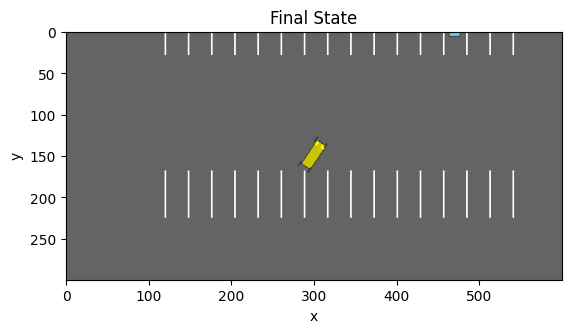

In [12]:
# Render the final image in the episode
plt.imshow(final_state_img)
plt.xlabel("x")
plt.ylabel("y")
plt.title("Final State")
plt.show()

In [13]:
#load the video of the episode
show_videos('./videos')

### 2.1 Build a dynamics model with NN


In [14]:
# reinitialize the env without recordvideo
env = gym.make("parking-v0")

In [15]:
#NN structure
class NN_DynamicsModel(nn.Module):
    name = 'NN'
    def __init__(self, state_size, action_size, hidden_size, dt):
        super().__init__()
        self.state_size, self.action_size, self.dt = state_size, action_size, dt
        self.layer1 = nn.Linear(state_size + action_size, hidden_size)
        self.layer2 = nn.Linear(hidden_size, state_size)

    def forward(self, x, u):
        """
            Predict x_{t+1} = f(x_t, u_t)
        :param x: a batch of states
        :param u: a batch of actions
        :return x_{t+1}
        """
        xu = torch.cat((x, u), -1)
        xu = F.relu(self.layer1(xu))
        dx = self.layer2(xu).squeeze()

        # note that our prediction is delta x: dx = x_{t+1} - x_{t},
        # so how to obtain x_{t+1}?

        x_next = dx+x
        return x_next

Build NN dynamics model:

In [16]:
#parameters to instantiate the NN model
state_size = env.observation_space.spaces["observation"].shape[0] #observation dimension
action_size = env.action_space.shape[0] #action dimension
hidden_size = 128 #width of the hidden layer
timestep_duration = 1/env.unwrapped.config["policy_frequency"] #timestep duration of the environment

#instatiate the NN model
dynamics_nn = NN_DynamicsModel(state_size, action_size, hidden_size, timestep_duration)  # REPLACE THE THREE DOTS WITH YOUR OWN CODE

In [17]:
#run a full episode with random actions and store the untrained nn predictions
state_data = []
pred_data = []
reward_data = []

#initialize the environment
env.reset()
done = False

while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)  # REPLACE THE THREE DOTS WITH YOUR OWN CODE

    state = obs["observation"]  # REPLACE THE THREE DOTS WITH YOUR OWN CODE

    pred = dynamics_nn(torch.Tensor(state), torch.Tensor(action)).detach().numpy()

    #store the data
    state_data.append(state)
    pred_data.append(pred)
    reward_data.append(reward)


env.close()

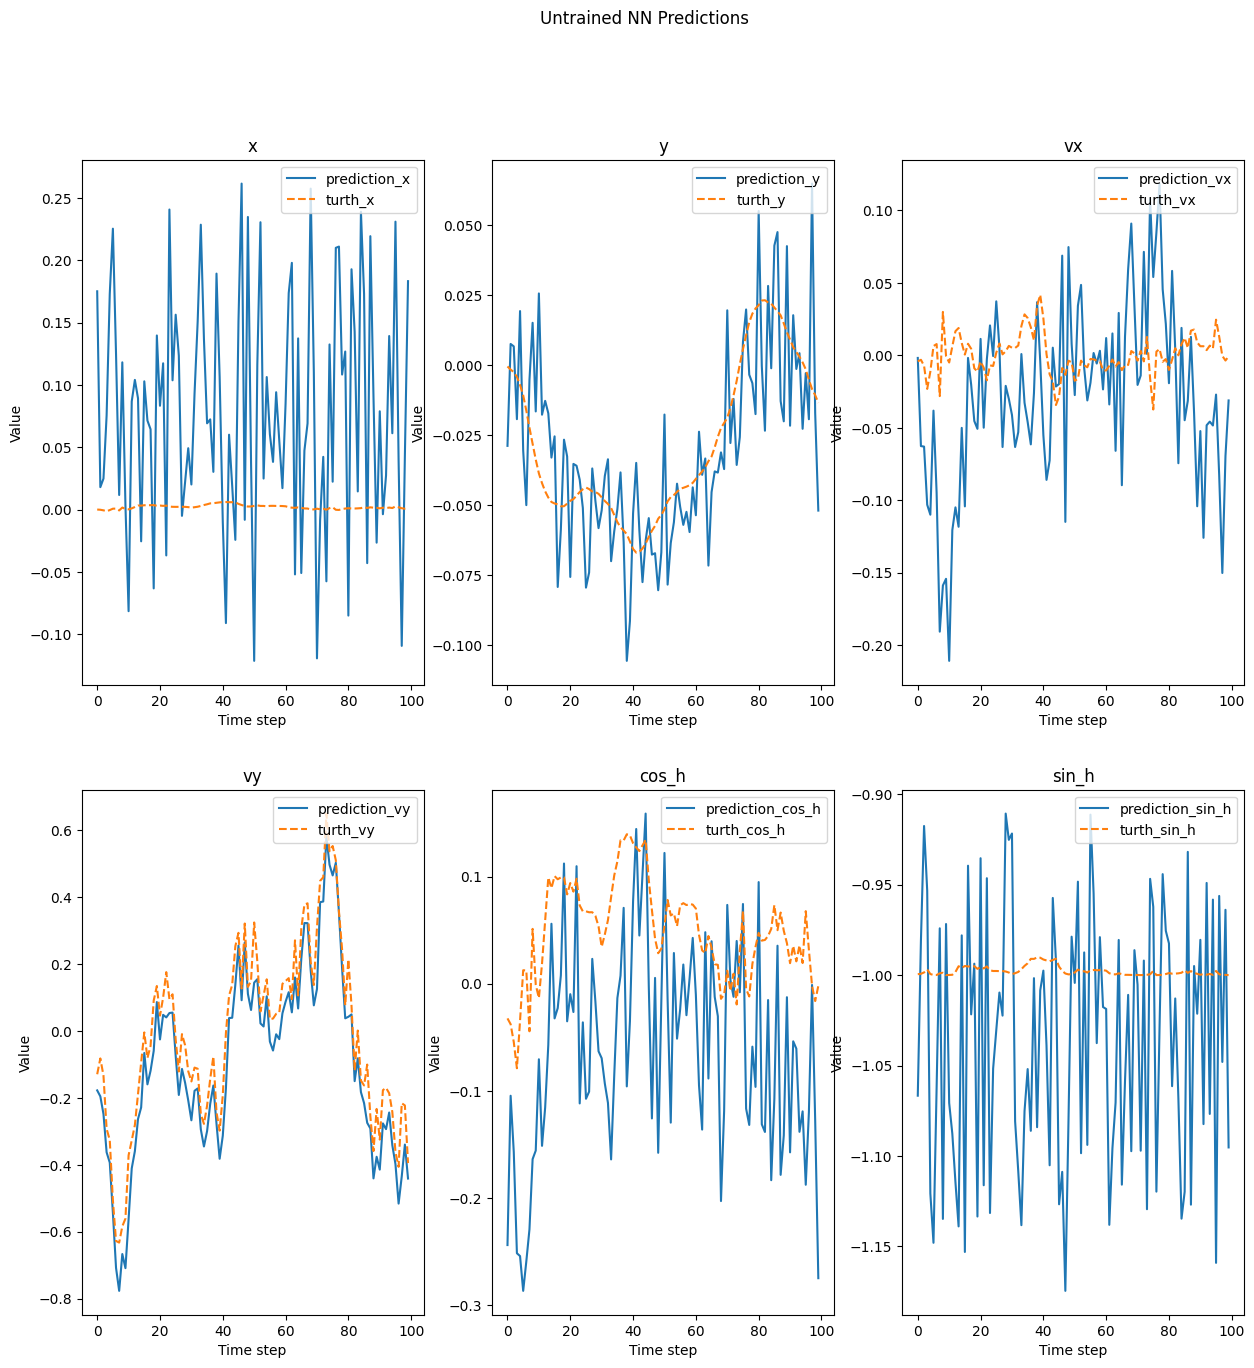

In [18]:
# Plot the true and predicted states
pred_data = np.array(pred_data)
state_data = np.array(state_data)
plt.figure(figsize=(15,15))
for i in range(state_data.shape[1]):
  plt.subplot(2,3,i+1)
  plt.plot(pred_data[:,i], label="prediction_"+features[i])
  plt.plot(state_data[:,i], "--",label= "turth_"+features[i])
  plt.legend(loc="upper right")
  plt.xlabel("Time step")
  plt.ylabel("Value")
  plt.title(features[i])
plt.suptitle("Untrained NN Predictions")
plt.show()

## 2.2 Model training

First, we randomly interact with the environment to produce a batch of experiences.
$$D = \{s_t, a_t, s_{t+1}\}_{t\in[1,N]}$$

In [19]:
#functions to create experiences dataset D

Transition = namedtuple('Transition', ['state', 'action', 'next_state'])

def collect_interaction_data(env, size=2000, action_repeat=1):
    data, done = [], True
    for _ in trange(size):
        action = env.action_space.sample() #random sample actions
        for _ in range(action_repeat):
            previous_obs = env.reset() if done else obs
            obs, reward, done, info = env.step(action)
            data.append(Transition(torch.Tensor(previous_obs["observation"]),
                                   torch.Tensor(action),
                                   torch.Tensor(obs["observation"])))
    return data

def transpose_batch(batch):
    return Transition(*map(torch.stack, zip(*batch)))

In [20]:
size = 2000  # REPLACE THE THREE DOTS WITH YOUR OWN CODE

data = collect_interaction_data(env, size=size)

print("Sample transition:", data[0])
print("Buffer size:", len(data))

  0%|          | 0/2000 [00:00<?, ?it/s]

Sample transition: Transition(state=tensor([ 0.0000,  0.0000,  0.0000, -0.0000,  0.5097, -0.8603]), action=tensor([0.9106, 0.6577]), next_state=tensor([ 4.4097e-04, -4.1723e-04,  9.3867e-02, -1.5607e-01,  5.1541e-01,
        -8.5694e-01]))
Buffer size: 2000


In [21]:
# Split dataset into training and validation

train_ratio =  0.7

train_data, validation_data = data[:int(train_ratio * len(data))], \
                              data[int(train_ratio * len(data)):]

In [22]:
# functions to train the model

def compute_loss(model, data_t, loss_func = torch.nn.MSELoss()):
    states, actions, next_states = data_t
    predictions = model(states, actions)
    return loss_func(predictions, next_states)

def train(model, train_data, validation_data, epochs=1500, learning_rate = 0.01):
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
    train_data_t = transpose_batch(train_data)
    validation_data_t = transpose_batch(validation_data)
    losses = np.full((epochs, 2), np.nan)

    for epoch in trange(epochs):
        # Compute loss gradient and step optimizer
        loss = compute_loss(model, train_data_t)
        validation_loss = compute_loss(model, validation_data_t)
        losses[epoch] = [loss.detach().numpy(), validation_loss.detach().numpy()]
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Plot losses
    plt.plot(losses)
    plt.yscale("log")
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.legend(["training", "validation"])
    plt.show()

Training the model

  0%|          | 0/1000 [00:00<?, ?it/s]

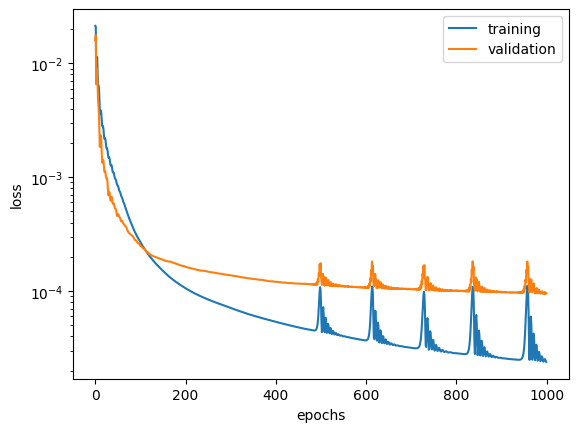

In [23]:
num_epochs = 1000 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
learning_rate = 1e-2 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
train(dynamics_nn, train_data, validation_data, epochs=num_epochs, learning_rate = learning_rate)

## 2.3 Predictions of the trained NN

In [24]:
dynamics_nn.eval() #set the trained model for use

#run a full episode with random actions and store the trained nn predictions
state_data = []
pred_data = []
reward_data = []

#initialize the environment
env.reset()
done = False

while not done:
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    state = obs["observation"]  # REPLACE THE THREE DOTS WITH YOUR OWN CODE

    pred = dynamics_nn(torch.Tensor(state), torch.Tensor(action)).detach().numpy()

    #store the data
    state_data.append(state)
    pred_data.append(pred)
    reward_data.append(reward)  # REPLACE THE THREE DOTS WITH YOUR OWN CODE
    final_state_img = env.render(mode="rgb_array")

env.close()

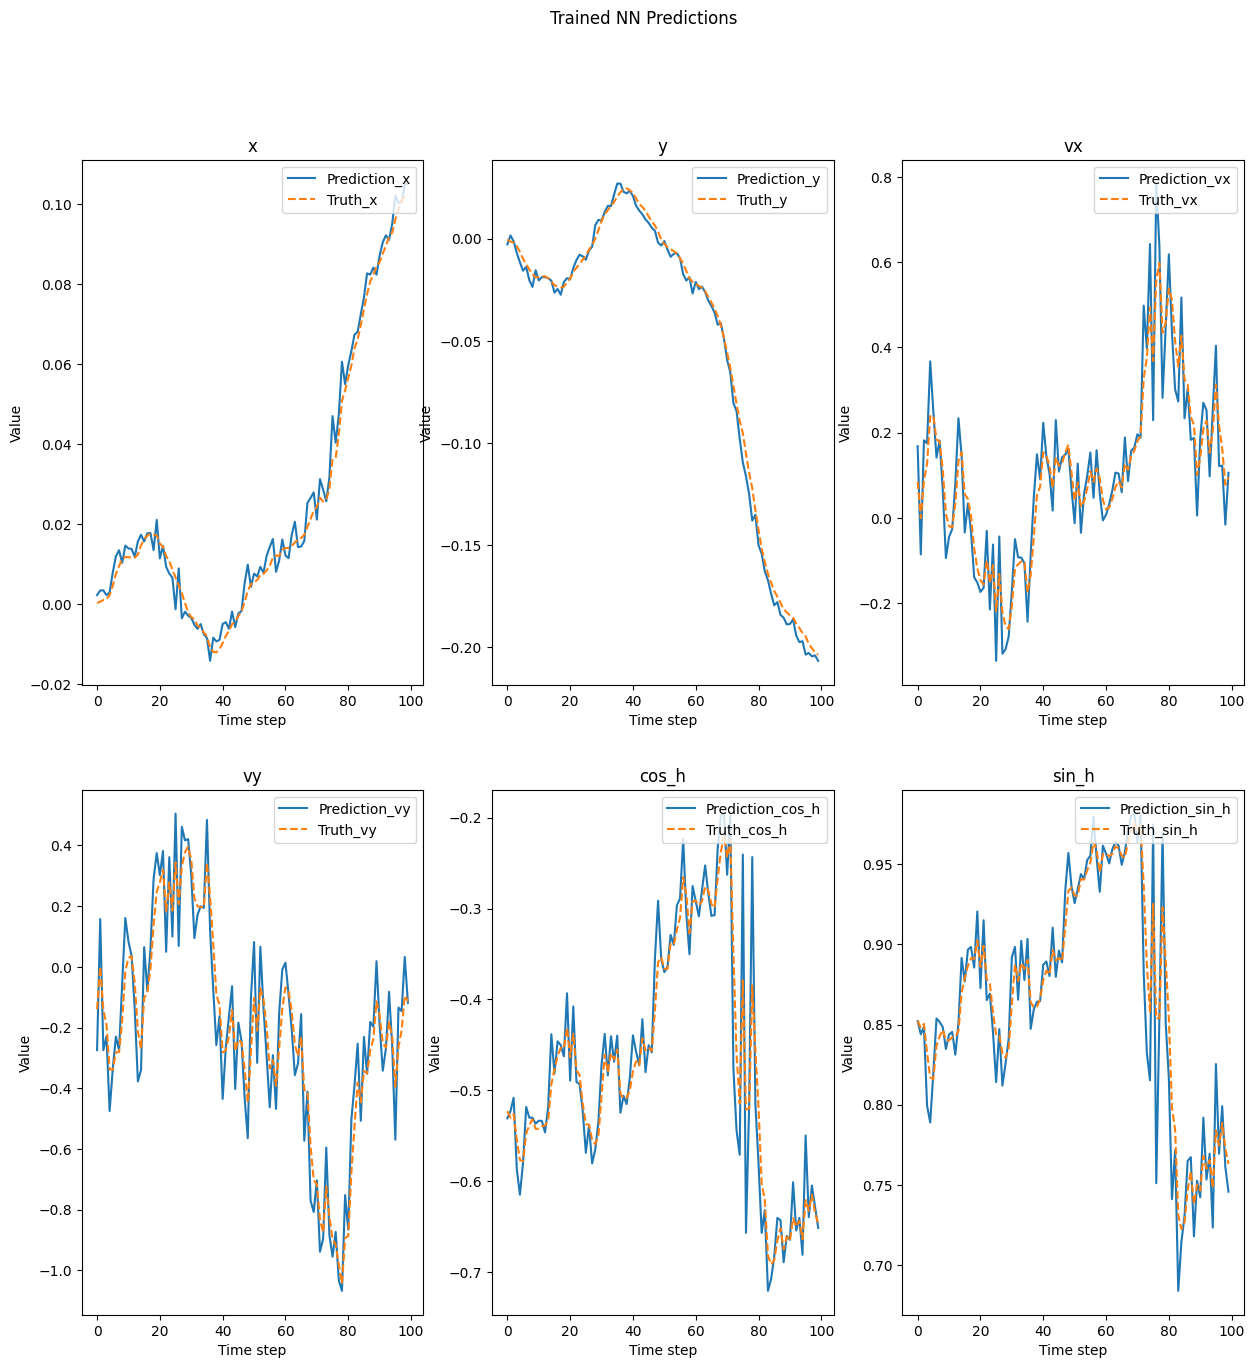

In [25]:
# Plot the true and predicted states
states = np.array(state_data)  # GT States for NN model training
preds = np.array(pred_data) # predictions states from NN model
plt.figure(figsize=(15,15))
for i in range(states.shape[1]):
  plt.subplot(2,3,i+1)
  plt.plot(preds[:,i], label= "Prediction_"+features[i])
  plt.plot(states[:,i], "--",label = "Truth_"+features[i])
  plt.legend(loc='upper right')
  plt.xlabel("Time step")
  plt.ylabel("Value")
  plt.title(features[i])
plt.suptitle(f"Trained NN Predictions")
plt.show()
nn_error = ((states-preds)**2).mean()


## CEM planner


In [26]:
#functions to help build the  CEM method
def predict_trajectory_actionlist(state, actions, model, action_repeat=1):
    states = []
    for action in actions:
        for _ in range(action_repeat):
            if model.name == 'GP':
                state = model(torch.cat((state, action), -1)).mean
            else:
                state = model(state, action)
            states.append(state)
    return torch.stack(states, dim=0)

def reward_model(states, goal, gamma=None):
    """
        The reward is a weighted L1-norm between the state and a goal
    :param Tensor states: a batch of states. shape: [batch_size, state_size].
    :param Tensor goal: a goal state. shape: [state_size].
    :param float gamma: a discount factor
    """
    goal = goal.expand(states.shape)
    reward_weigths = torch.Tensor(env.unwrapped.config["reward_weights"])
    rewards = -torch.pow(torch.norm((states-goal)*reward_weigths, p=1, dim=-1), 0.5)
    if gamma:
        time = torch.arange(rewards.shape[0], dtype=torch.float).unsqueeze(-1).expand(rewards.shape)
        rewards *= torch.pow(gamma, time)
    return rewards

We now use the learnt dynamics model $f_\theta$ for planning.
In order to solve the optimal control problem, we use a sampling-based optimization algorithm: the **Cross-Entropy Method** (`CEM`). It is an optimization algorithm applicable to problems that are both **combinatorial** and **continuous**, which is our case: find the best performing sequence of actions.

In [27]:
def cem_planner(state, goal, action_size, model, horizon=5, population=10, selection=5, iterations=5):
    state = state.expand(population, -1)
    action_mean = torch.zeros(horizon, 1, action_size)
    action_std = torch.ones(horizon, 1, action_size)

    for iter_num in range(iterations):
        # 1. Draw sample sequences of actions from a normal distribution
        actions = action_mean + action_std * torch.randn(horizon, population, action_size)
        actions = torch.clamp(actions, min=env.action_space.low.min(), max=env.action_space.high.max())
        states = predict_trajectory_actionlist(state, actions, model, action_repeat=horizon)

        # 2. Fit the distribution to the top-k performing sequences
        returns = reward_model(states, goal).sum(dim=0)
        _, best = returns.topk(selection, largest=True, sorted=False)
        best_actions = actions[:, best, :]

        action_std = best_actions.std(dim=1, unbiased=False, keepdim=True)
        action_mean = best_actions.mean(dim=1, keepdim=True)  # REPLACE THE THREE DOTS WITH YOUR OWN CODE

    return action_mean[0].squeeze(dim=0)


Example of using the CEM to select actions:

In [28]:
# Run the planner on a sample transition

obs = env.reset() #reset the environment to start

#run CEM to get actions using NN dynamics model
H = 3 #planning horizon
K = 10 #population size

action_nn = cem_planner(torch.Tensor(obs["observation"]),
                     torch.Tensor(obs["desired_goal"]),
                     env.action_space.shape[0], dynamics_nn,
                     horizon=H, population=K)

print("Planned action:", action_nn)

Planned action: tensor([-0.8538,  0.1893])


## 2.4. CEM with NN model

In [29]:
#run an episode for nn

#run an episode with random actions for at most n time steps
n = 20 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
H = 5 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
K = 10 # REPLACE THE THREE DOTS WITH YOUR OWN CODE

import time

nn_time = []
state_data_nn = []
reward_data_nn = []

obs = env.reset()
done = False
i=0 #iterates




while (not done and i < n) : # planning and train with n epoch

    #use CEM with NN model to select actions
    start = time.time()
    state = obs["observation"]
    target = obs["desired_goal"]
    # REPLACE THE THREE DOTS WITH YOUR OWN CODE
    action = action_nn
    obs, reward, done, info = env.step(action)

    end = time.time()
    #store the data
    nn_time.append(end-start)
    state_data_nn.append(obs["observation"])
    reward_data_nn.append(reward)

    i+=1
    print(i, end="\n")

env.close()
nn_reward = reward_data_nn

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


Text(0.5, 1.0, 'CEM NN Rewards Over Time')

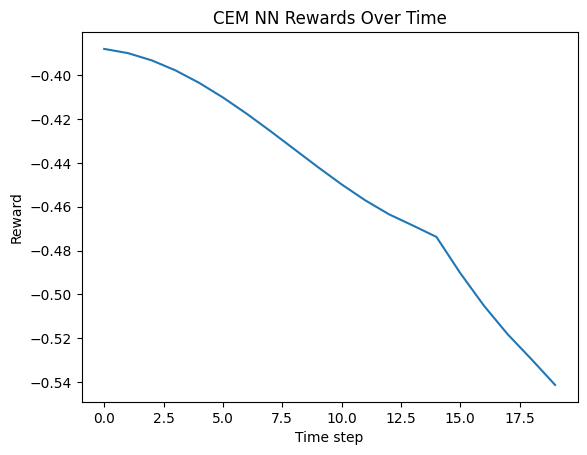

In [30]:
# Plot the rewards over time step

plt.plot(nn_reward) # REPLACE THE THREE DOTS WITH YOUR OWN CODE
plt.xlabel("Time step")
plt.ylabel("Reward")
plt.title("CEM NN Rewards Over Time")

### 3.1 Build a dynamics model with a Gaussian process

In [31]:
#GP model structure
#More details are available in gpytorch documentation: https://docs.gpytorch.ai/en/stable/

import gpytorch
from torch.utils.data import DataLoader

class MultitaskGPModel(gpytorch.models.ExactGP):
    name = 'GP'
    def __init__(self, train_x, train_y, likelihood, num_tasks=6): # number tasks is equivalent to the output dim
        super(MultitaskGPModel, self).__init__(train_x, train_y, likelihood)
        self.num_tasks = num_tasks
        self.mean_module = gpytorch.means.MultitaskMean(
            gpytorch.means.ConstantMean(), num_tasks=num_tasks
        )
        self.covar_module = gpytorch.kernels.MultitaskKernel(
            gpytorch.kernels.RBFKernel(), num_tasks=num_tasks, rank=1
        )

    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        dists = gpytorch.distributions.MultitaskMultivariateNormal(mean_x + x[:,:self.num_tasks], covar_x)
        return dists

Build data pre-processing and prediction functions

In [32]:
#functions to prepare the data for GP training

def GP_dataloader_process(data, train_ratio = 0.3):
    # Split dataset into training and validation
    data_n = transpose_batch(data)
    inputs = torch.cat((data_n[0], data_n[1]), dim=1)
    targets = data_n[2]
    data_for_loader = []

    for i in range(inputs.shape[0]):
      data_for_loader.append([inputs[i], targets[i]])

    # prepare data for loader
    train_data_for_loader, validation_data_for_loader = data_for_loader[:int(train_ratio * len(data))], data_for_loader[int(train_ratio * len(data)):]

    # prepare data for GP
    return train_data_for_loader, validation_data_for_loader

def GP_data_prepare(data, train_ratio = 0.3):
    # Split dataset into training and validation
    train_data, validation_data = data[:int(train_ratio * len(data))], \
                                  data[int(train_ratio * len(data)):]
    train_data_t = transpose_batch(train_data)
    states, actions, next_states = train_data_t
    train_x = torch.cat((states, actions), -1)
    train_y = next_states

    validation_data_t = transpose_batch(validation_data)
    val_states, val_actions, val_next_states = validation_data_t
    val_x = torch.cat((val_states, val_actions), -1)
    val_y = val_next_states
    return [train_x, train_y], [val_x, val_y]

def predict_trajectory(state, action, model, action_repeat=1):
    states = []
    for _ in range(action_repeat):
        if model.name == 'GP':
            state = model(torch.cat((state, action), -1)).mean
        else:
            state = model(state, action)
        states.append(state)
    return torch.stack(states, dim=0)

Training the GP model

In [33]:
train_ratio = 0.2

#prepare and split the dataset
train_data, validation_data = GP_data_prepare(data, train_ratio=train_ratio)
train_x, train_y = train_data
val_x, val_y = validation_data

# construct dynamics model
output_dim = 6 #the dimension of the state variables
likelihood = gpytorch.likelihoods.MultitaskGaussianLikelihood(num_tasks=output_dim, noise_constraint=GreaterThan(0.000001))

#instantiate the model
dynamics_gp = MultitaskGPModel(train_x, train_y, likelihood, num_tasks=output_dim)

In [34]:
learning_rate = 0.2 # REPLACE THE THREE DOTS WITH YOUR OWN CODE
epochs = 15 # REPLACE THE THREE DOTS WITH YOUR OWN CODE

mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, dynamics_gp) #loss function
optimizer = torch.optim.Adam([{'params': dynamics_gp.parameters()},], lr=learning_rate) #adam optimizer

losses = np.full((epochs, 2), np.nan) #instantiate variables to store loss values

In [35]:

#iterate the training
for i in trange(epochs):
    dynamics_gp.train()
    likelihood.train()
    optimizer.zero_grad()

    output = dynamics_gp(train_x)
    loss = -mll(output, train_y) #compute the loss
    loss.backward() #backprop the error
    optimizer.step() #update the nn params

    dynamics_gp.eval()
    likelihood.eval()
    val_out = dynamics_gp(val_x)
    validation_loss = -mll(val_out, val_y) #compute the validation loss

    losses[i] = [loss.detach().numpy(), validation_loss.detach().numpy()] #store the computed loss

    print('Iter %d/%d - Loss: %.3f - Val Los: %.3f' % (i + 1, epochs, loss.item(), validation_loss.item()))

  0%|          | 0/15 [00:00<?, ?it/s]

Iter 1/15 - Loss: 1.202 - Val Los: 1.076
Iter 2/15 - Loss: 1.110 - Val Los: 0.987
Iter 3/15 - Loss: 1.018 - Val Los: 0.898
Iter 4/15 - Loss: 0.929 - Val Los: 0.808
Iter 5/15 - Loss: 0.839 - Val Los: 0.717
Iter 6/15 - Loss: 0.747 - Val Los: 0.624
Iter 7/15 - Loss: 0.654 - Val Los: 0.531
Iter 8/15 - Loss: 0.559 - Val Los: 0.436
Iter 9/15 - Loss: 0.464 - Val Los: 0.340
Iter 10/15 - Loss: 0.369 - Val Los: 0.244
Iter 11/15 - Loss: 0.272 - Val Los: 0.145
Iter 12/15 - Loss: 0.174 - Val Los: 0.047
Iter 13/15 - Loss: 0.076 - Val Los: -0.052
Iter 14/15 - Loss: -0.023 - Val Los: -0.151
Iter 15/15 - Loss: -0.122 - Val Los: -0.252


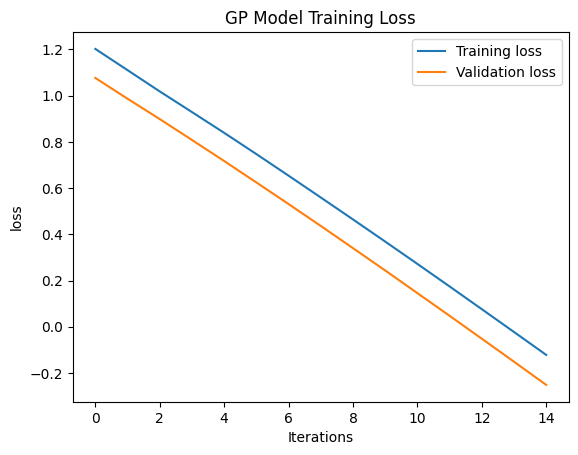

In [36]:
# Plot the training and validation losses
# losses = [training loss, validation loss]

plt.plot(losses[:,0], label = "Training loss")
plt.plot(losses[:,1], label = "Validation loss")
plt.xlabel("Iterations")
plt.ylabel("loss")
plt.legend()
plt.title("GP Model Training Loss")
plt.show()

##3.2 Using the trained model for prediction

In [37]:
#run an episode with random actions for at most n time steps
n = 20

state_data_gp = []
pred_data_gp = []
reward_data_gp = []

env.reset()
done = False
i=0 #iterates

while (not done and i < n) :

    # REPLACE THE THREE DOTS WITH YOUR OWN CODE
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)

    state = torch.Tensor(obs['observation']).unsqueeze(0) #convert the state to proper format
    action = torch.Tensor(action).unsqueeze(0)  #convert the action to proper format

    pred = predict_trajectory(state, action, dynamics_gp, action_repeat=1).detach().numpy() #GP prediction

    #store the data
    # REPLACE THE THREE DOTS WITH YOUR OWN CODE
    state_data_gp.append(state.detach().numpy().reshape(-1,)) # store in tensor
    pred_data_gp.append(pred.reshape(-1,))
    reward_data_gp.append(reward)


    i+=1
    print(i, end="\n")
env.close()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


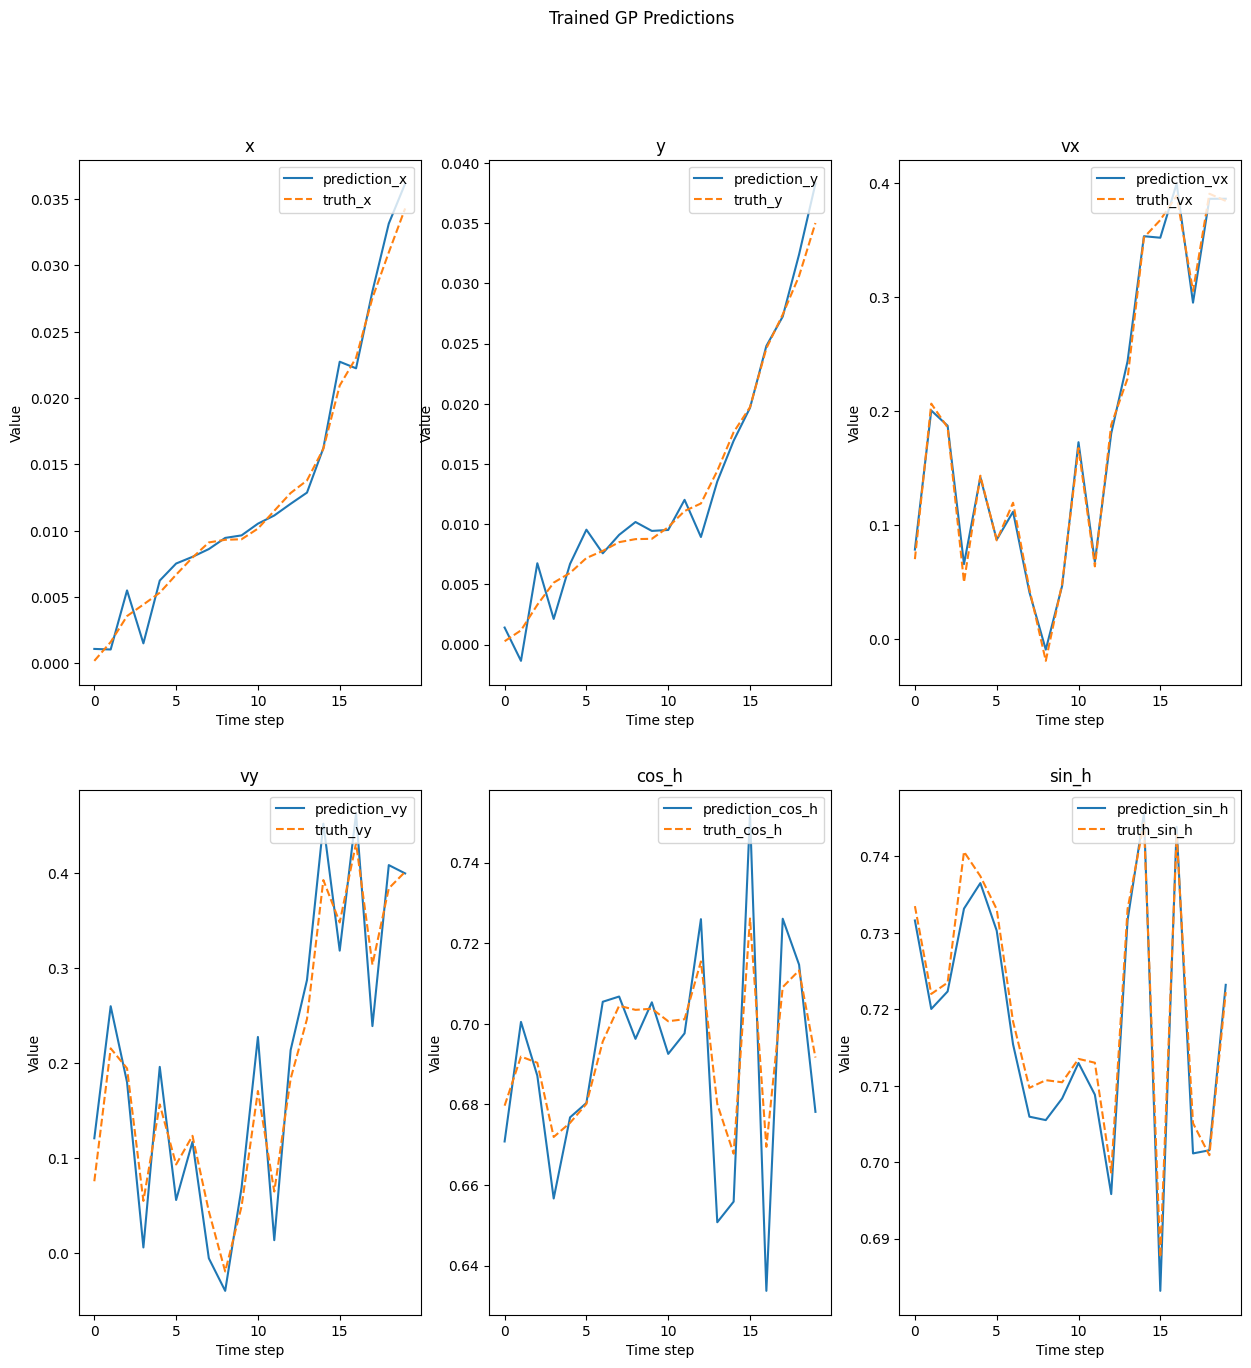

In [38]:
# Plot the true and predicted states
state_data_gp = np.array(state_data_gp)
pred_data_gp = np.array(pred_data_gp)
reward_data = np.array(reward_data)
plt.figure(figsize=(15,15))
for i in range(state.shape[1]):
  plt.subplot(2,3,i+1)
  plt.plot(pred_data_gp[:,i], label="prediction_"+features[i])
  plt.plot(state_data_gp[:,i], "--",label="truth_"+features[i])
  plt.legend(loc='upper right')
  plt.xlabel("Time step")
  plt.ylabel("Value")
  plt.title(features[i])
plt.suptitle("Trained GP Predictions")
plt.show()

In [39]:
pred_data_gp[0]

array([0.00109627, 0.001418  , 0.07840183, 0.1208156 , 0.67081183,
       0.73162234], dtype=float32)

## 3.3. CEM with GP model

In [40]:
#run an episode for GP

#run an episode with random actions for at most n time steps
n = 20 # REPLACE THE THREE DOTS WITH YOUR OWN CODE

state_data = []
reward_data = []
gp_time = []

obs = env.reset()
done = False
i=0 #iterates
state = torch.Tensor(obs['observation']).unsqueeze(0)
target = torch.Tensor(obs['desired_goal']).unsqueeze(0)
H = 5 # planning horizon
K = 10 # population size

while (not done and i < n) :

    start = time.time()
    # REPLACE THE THREE DOTS WITH YOUR OWN CODE
    action = cem_planner(state,
                         target,
                         env.action_space.shape[0], dynamics_gp,
                         horizon=H, population=K) #use CEM with GP model to select actions(use the action )
    obs, reward, done, info = env.step(action)

    state = torch.Tensor(obs['observation']).unsqueeze(0) #convert the state to proper format
    action = torch.Tensor(action).unsqueeze(0)  #convert the action to proper format

    pred = predict_trajectory(state, action, dynamics_gp, action_repeat=1).detach().numpy() #GP prediction

    end = time.time()

    #store the data
    state_data.append(np.array(state).reshape(-1,))
    reward_data.append(reward)
    gp_time.append(end-start)

    i+=1
    print(i, end="\n")

env.close()
gp_reward = reward_data

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


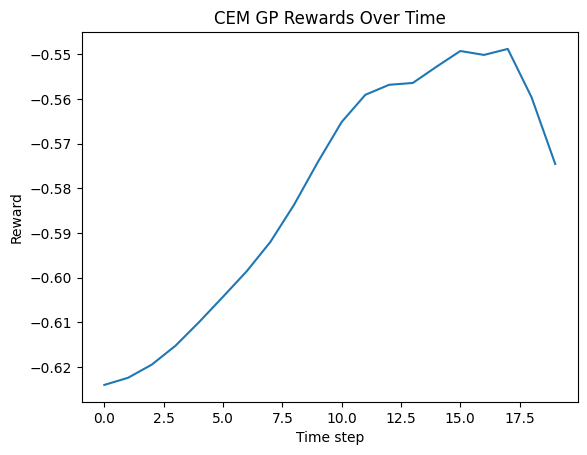

In [41]:
# Plot the rewards over time step

plt.plot(gp_reward)
plt.title("CEM GP Rewards Over Time")
plt.xlabel("Time step")
plt.ylabel("Reward")
plt.show()

In [42]:
# Get the final reward (when using NN and GP with CEM)
print("Final reward of NN with CEM: ", nn_reward[-1])
print("Final reward of GP with CEM: ", gp_reward[-1])

Final reward of NN with CEM:  -0.5413685236403645
Final reward of GP with CEM:  -0.5745496406173378


Computing the prediction error, and computation time between NN and GP

In [43]:
# Compute the prediction error of NN and GP models during the planning horizon
nn_error = ((state - pred)**2).mean()
gp_error = ((state_data_gp -pred_data_gp)**2).mean()



# Get the computation time of running CEM with NN (from 2.4)and GP (from 3.3)
nn_total_time = sum(nn_time)
gp_total_time = sum(gp_time)

print(f"Neural network prediction error: {nn_error}; Neural network computation time: {nn_total_time}")
print(f"Gaussian process prediction error: {gp_error}; Gaussian process computation time: {gp_total_time}")




Neural network prediction error: 0.004192639607936144; Neural network computation time: 0.30714941024780273
Gaussian process prediction error: 0.00031115300953388214; Gaussian process computation time: 95.67181277275085


##Visualize a few episodes [Optional]

Here is a code to visualize a few episodes with CEM action planner.  This is optional, but might be helpful to gain insights.

En voiture, Simone!

In [44]:
display = Display(visible=0, size=(1400, 900))
display.start()
env = gym.make("parking-v0") #instantiate the parking environment
VIDEO_PATH = './video-final' #designate the video path
env = RecordVideo(env, video_folder=VIDEO_PATH, episode_trigger=lambda e: True, new_step_api=True)
env.unwrapped.set_record_video_wrapper(env) #set up virtual monitor to store the video files at VIDEO_PATH dir
num_episodes = 5
H = 6
K = 25
iterations = 15

#select the dynamic model
selected_dynamic_model = dynamics_nn #we will use NN model for its fast computation

for episode in trange(num_episodes):
    obs = env.reset()
    done=False
    while (not done):
        action = cem_planner(torch.Tensor(obs["observation"]),
                             torch.Tensor(obs["desired_goal"]),
                             env.action_space.shape[0], selected_dynamic_model,
                             horizon=H, population=K, iterations=iterations)
        obs, reward, done, _, info = env.step(action.numpy())
env.close()

  0%|          | 0/5 [00:00<?, ?it/s]

In [45]:
show_videos(VIDEO_PATH)